In [69]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [70]:
# Loading the dataset
dataset = pd.read_csv('pulsar_stars.csv')

1. Once the dataset is loaded, let's see some relevant information about the dataset such as column's titles and types, number of records and shape.

In [71]:
# EDA
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 Mean of the integrated profile                  17898 non-null float64
 Standard deviation of the integrated profile    17898 non-null float64
 Excess kurtosis of the integrated profile       17898 non-null float64
 Skewness of the integrated profile              17898 non-null float64
 Mean of the DM-SNR curve                        17898 non-null float64
 Standard deviation of the DM-SNR curve          17898 non-null float64
 Excess kurtosis of the DM-SNR curve             17898 non-null float64
 Skewness of the DM-SNR curve                    17898 non-null float64
target_class                                     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB
None


Now, Pay close attention to this plot. Note that the proportion between classes in the dataset is very imbalanced, this is a common problem encountered among many datasets in the real-world. This leads to the accuracy paradox, which implies that we'll need to use more than the usual approach to achieve a reasonable performance while training the neural network.

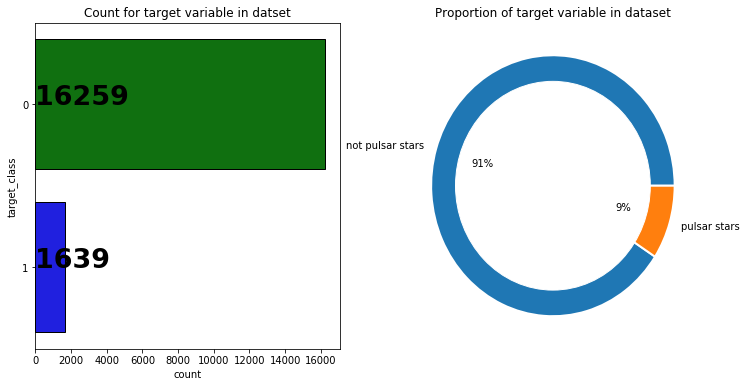

In [72]:
plt.figure(figsize=(12,6))
plt.subplot(121)
ax = sns.countplot(y = dataset["target_class"],
                   palette=["g","b"],
                   linewidth=1,
                   edgecolor="k"*2)
for i,j in enumerate(dataset["target_class"].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize = 27)
plt.title("Count for target variable in datset")


plt.subplot(122)
plt.pie(dataset["target_class"].value_counts().values,
        labels=["not pulsar stars","pulsar stars"],
        autopct="%1.0f%%",wedgeprops={"linewidth":2,"edgecolor":"white"})
figure = plt.Circle((0,0),.8,color = "white")
plt.gca().add_artist(figure)
plt.subplots_adjust(wspace = .2)
plt.title("Proportion of target variable in dataset")
plt.savefig('proportion_between_classes.jpg')

2. Now, let's divide our dataset into two subsets: data and target. In this case, I am doing a Standardization procedure in order obtain zero mean and a standard deviation equals to 1. This preserves Gaussian and Gaussian-like distributions whilst normalizing the central tendencies for each attribute.

In [73]:
# Droping the target and assigning the rest to the data variable
data = dataset.drop(['target_class'], axis=1)

# Standardization procedure
scaler = StandardScaler()
data = scaler.fit_transform(data)

target = dataset[['target_class']]

In [74]:
# UNDERSAMPLING Saved for later improvement
#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(ratio = {0 : 8000, 1 : 1639}, return_indices=True)
#X_rus, y_rus, id_rus = rus.fit_sample(data, target)

In [75]:
# Construct the training and testing splits 
trainX, testX, trainY, testY = train_test_split(data, target, test_size=0.25)

Machine Learning algorithms works better when integer labels are transformed into vector labels. In order to accomplish this transformation I will instantiate a LabelBinarizer object and apply the transformation methods into our trainY and testY sets.

In [76]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

With keras, it is possible to define models to our neural network (nn). In this case, we are going to work with a Sequential nn, which is just the nn as we already know, i.e., each layer has as its input the output of the former layer. It is worth mention that our neural network is 8-4-2-1.

We are going to use the Stochastic Gradient Descent technique as an optimizer, initially with a learning rate = 0.12 and a momentum = 0.4. Furthermore, as this is a binary classification problem, in this case a common loss function to adopt is the binary cross-entropy.

In [77]:
def create_baseline():
    sgd = SGD(0.12, momentum=0.4)
    model = Sequential()
    model.add(Dense(4, input_shape=(8,), activation='sigmoid'))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

As we have imbalanced classes, we need to tell the network that during training, the positive class is more important than the negative. This has been done through the class weight dictionary, where I am telling the network that during the training positive data points are 2 times more important than the negative ones. Now it is time to evaluate this model using stratified cross validation in the scikit-learn framework. Doing this we can get the accuracy of our predictions with less sensibility to the training data.

In [78]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# Instantiating the estimator
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, 
                            batch_size=128, verbose=2)

# Weighting the classes
class_weight= {0 : 1., 1: 2.}

# Assigning the results
results = cross_val_score(estimator, data, target, cv=kfold, fit_params={'class_weight':class_weight})

print("Results: %.4f%% (%.4f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
 - 2s - loss: 0.4730 - acc: 0.9079
Epoch 2/100
 - 0s - loss: 0.3657 - acc: 0.9084
Epoch 3/100
 - 0s - loss: 0.2561 - acc: 0.9543
Epoch 4/100
 - 0s - loss: 0.1887 - acc: 0.9751
Epoch 5/100
 - 0s - loss: 0.1563 - acc: 0.9760
Epoch 6/100
 - 0s - loss: 0.1406 - acc: 0.9777
Epoch 7/100
 - 0s - loss: 0.1325 - acc: 0.9783
Epoch 8/100
 - 0s - loss: 0.1281 - acc: 0.9783
Epoch 9/100
 - 0s - loss: 0.1253 - acc: 0.9785
Epoch 10/100
 - 0s - loss: 0.1236 - acc: 0.9782
Epoch 11/100
 - 0s - loss: 0.1222 - acc: 0.9784
Epoch 12/100
 - 0s - loss: 0.1213 - acc: 0.9786
Epoch 13/100
 - 0s - loss: 0.1202 - acc: 0.9788
Epoch 14/100
 - 0s - loss: 0.1195 - acc: 0.9791
Epoch 15/100
 - 0s - loss: 0.1187 - acc: 0.9786
Epoch 16/100
 - 0s - loss: 0.1183 - acc: 0.9788
Epoch 17/100
 - 0s - loss: 0.1176 - acc: 0.9793
Epoch 18/100
 - 0s - loss: 0.1168 - acc: 0.9788
Epoch 19/100
 - 0s - loss: 0.1168 - acc: 0.9797
Epoch 20/100
 - 0s - loss: 0.1162 - acc: 0.9791
Epoch 21/100
 - 0s - loss: 0.1158 - acc: 0.9794
E

 - 0s - loss: 0.1102 - acc: 0.9790
Epoch 73/100
 - 0s - loss: 0.1100 - acc: 0.9786
Epoch 74/100
 - 0s - loss: 0.1097 - acc: 0.9786
Epoch 75/100
 - 0s - loss: 0.1096 - acc: 0.9781
Epoch 76/100
 - 0s - loss: 0.1096 - acc: 0.9784
Epoch 77/100
 - 0s - loss: 0.1095 - acc: 0.9781
Epoch 78/100
 - 0s - loss: 0.1094 - acc: 0.9786
Epoch 79/100
 - 0s - loss: 0.1093 - acc: 0.9789
Epoch 80/100
 - 0s - loss: 0.1095 - acc: 0.9787
Epoch 81/100
 - 0s - loss: 0.1094 - acc: 0.9785
Epoch 82/100
 - 0s - loss: 0.1091 - acc: 0.9783
Epoch 83/100
 - 0s - loss: 0.1090 - acc: 0.9786
Epoch 84/100
 - 0s - loss: 0.1092 - acc: 0.9786
Epoch 85/100
 - 0s - loss: 0.1091 - acc: 0.9789
Epoch 86/100
 - 0s - loss: 0.1089 - acc: 0.9788
Epoch 87/100
 - 0s - loss: 0.1090 - acc: 0.9787
Epoch 88/100
 - 0s - loss: 0.1088 - acc: 0.9784
Epoch 89/100
 - 0s - loss: 0.1088 - acc: 0.9787
Epoch 90/100
 - 0s - loss: 0.1087 - acc: 0.9784
Epoch 91/100
 - 0s - loss: 0.1082 - acc: 0.9790
Epoch 92/100
 - 0s - loss: 0.1087 - acc: 0.9785
Epoch

Epoch 44/100
 - 0s - loss: 0.1093 - acc: 0.9796
Epoch 45/100
 - 0s - loss: 0.1093 - acc: 0.9794
Epoch 46/100
 - 0s - loss: 0.1088 - acc: 0.9795
Epoch 47/100
 - 0s - loss: 0.1089 - acc: 0.9796
Epoch 48/100
 - 0s - loss: 0.1088 - acc: 0.9795
Epoch 49/100
 - 0s - loss: 0.1083 - acc: 0.9795
Epoch 50/100
 - 0s - loss: 0.1083 - acc: 0.9792
Epoch 51/100
 - 0s - loss: 0.1085 - acc: 0.9791
Epoch 52/100
 - 0s - loss: 0.1082 - acc: 0.9790
Epoch 53/100
 - 0s - loss: 0.1080 - acc: 0.9790
Epoch 54/100
 - 0s - loss: 0.1080 - acc: 0.9790
Epoch 55/100
 - 0s - loss: 0.1078 - acc: 0.9793
Epoch 56/100
 - 0s - loss: 0.1077 - acc: 0.9791
Epoch 57/100
 - 0s - loss: 0.1074 - acc: 0.9792
Epoch 58/100
 - 0s - loss: 0.1074 - acc: 0.9793
Epoch 59/100
 - 0s - loss: 0.1074 - acc: 0.9792
Epoch 60/100
 - 0s - loss: 0.1072 - acc: 0.9789
Epoch 61/100
 - 0s - loss: 0.1069 - acc: 0.9795
Epoch 62/100
 - 0s - loss: 0.1069 - acc: 0.9793
Epoch 63/100
 - 0s - loss: 0.1067 - acc: 0.9795
Epoch 64/100
 - 0s - loss: 0.1068 - acc:

 - 0s - loss: 0.1194 - acc: 0.9789
Epoch 16/100
 - 0s - loss: 0.1183 - acc: 0.9784
Epoch 17/100
 - 0s - loss: 0.1174 - acc: 0.9791
Epoch 18/100
 - 0s - loss: 0.1166 - acc: 0.9789
Epoch 19/100
 - 0s - loss: 0.1158 - acc: 0.9787
Epoch 20/100
 - 0s - loss: 0.1153 - acc: 0.9790
Epoch 21/100
 - 0s - loss: 0.1145 - acc: 0.9790
Epoch 22/100
 - 0s - loss: 0.1138 - acc: 0.9794
Epoch 23/100
 - 0s - loss: 0.1132 - acc: 0.9794
Epoch 24/100
 - 0s - loss: 0.1129 - acc: 0.9796
Epoch 25/100
 - 0s - loss: 0.1124 - acc: 0.9796
Epoch 26/100
 - 0s - loss: 0.1120 - acc: 0.9799
Epoch 27/100
 - 0s - loss: 0.1115 - acc: 0.9798
Epoch 28/100
 - 0s - loss: 0.1111 - acc: 0.9799
Epoch 29/100
 - 0s - loss: 0.1109 - acc: 0.9798
Epoch 30/100
 - 0s - loss: 0.1102 - acc: 0.9803
Epoch 31/100
 - 0s - loss: 0.1101 - acc: 0.9803
Epoch 32/100
 - 0s - loss: 0.1099 - acc: 0.9803
Epoch 33/100
 - 0s - loss: 0.1096 - acc: 0.9801
Epoch 34/100
 - 0s - loss: 0.1093 - acc: 0.9803
Epoch 35/100
 - 0s - loss: 0.1091 - acc: 0.9805
Epoch

 - 0s - loss: 0.1057 - acc: 0.9808
Epoch 87/100
 - 0s - loss: 0.1056 - acc: 0.9804
Epoch 88/100
 - 0s - loss: 0.1057 - acc: 0.9803
Epoch 89/100
 - 0s - loss: 0.1054 - acc: 0.9808
Epoch 90/100
 - 0s - loss: 0.1056 - acc: 0.9806
Epoch 91/100
 - 0s - loss: 0.1056 - acc: 0.9802
Epoch 92/100
 - 0s - loss: 0.1054 - acc: 0.9806
Epoch 93/100
 - 0s - loss: 0.1054 - acc: 0.9804
Epoch 94/100
 - 0s - loss: 0.1052 - acc: 0.9807
Epoch 95/100
 - 0s - loss: 0.1055 - acc: 0.9806
Epoch 96/100
 - 0s - loss: 0.1053 - acc: 0.9808
Epoch 97/100
 - 0s - loss: 0.1052 - acc: 0.9806
Epoch 98/100
 - 0s - loss: 0.1048 - acc: 0.9803
Epoch 99/100
 - 0s - loss: 0.1050 - acc: 0.9809
Epoch 100/100
 - 0s - loss: 0.1053 - acc: 0.9805
Epoch 1/100
 - 2s - loss: 0.4689 - acc: 0.9082
Epoch 2/100
 - 0s - loss: 0.3579 - acc: 0.9084
Epoch 3/100
 - 0s - loss: 0.2509 - acc: 0.9518
Epoch 4/100
 - 0s - loss: 0.1851 - acc: 0.9755
Epoch 5/100
 - 0s - loss: 0.1543 - acc: 0.9769
Epoch 6/100
 - 0s - loss: 0.1398 - acc: 0.9772
Epoch 7/10

Epoch 58/100
 - 0s - loss: 0.1065 - acc: 0.9804
Epoch 59/100
 - 0s - loss: 0.1064 - acc: 0.9803
Epoch 60/100
 - 0s - loss: 0.1065 - acc: 0.9803
Epoch 61/100
 - 0s - loss: 0.1064 - acc: 0.9802
Epoch 62/100
 - 0s - loss: 0.1060 - acc: 0.9804
Epoch 63/100
 - 0s - loss: 0.1063 - acc: 0.9804
Epoch 64/100
 - 0s - loss: 0.1062 - acc: 0.9807
Epoch 65/100
 - 0s - loss: 0.1061 - acc: 0.9797
Epoch 66/100
 - 0s - loss: 0.1061 - acc: 0.9805
Epoch 67/100
 - 0s - loss: 0.1058 - acc: 0.9802
Epoch 68/100
 - 0s - loss: 0.1059 - acc: 0.9801
Epoch 69/100
 - 0s - loss: 0.1059 - acc: 0.9798
Epoch 70/100
 - 0s - loss: 0.1058 - acc: 0.9798
Epoch 71/100
 - 0s - loss: 0.1057 - acc: 0.9802
Epoch 72/100
 - 0s - loss: 0.1052 - acc: 0.9803
Epoch 73/100
 - 0s - loss: 0.1057 - acc: 0.9802
Epoch 74/100
 - 0s - loss: 0.1052 - acc: 0.9804
Epoch 75/100
 - 0s - loss: 0.1051 - acc: 0.9801
Epoch 76/100
 - 0s - loss: 0.1055 - acc: 0.9802
Epoch 77/100
 - 0s - loss: 0.1050 - acc: 0.9803
Epoch 78/100
 - 0s - loss: 0.1052 - acc:

In [79]:
print(results)

[0.97765363 0.98324022 0.98324022 0.97988827 0.98156424 0.97821229
 0.97206704 0.97765363 0.97486033 0.9787472 ]


Now that we have obtained the accuracy of our model predictions, let's fit the model again under the same conditions as we did before and get some statistics to plot and visualize our results. 

In [80]:
model = create_baseline()

H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              batch_size=128, epochs=100, class_weight=class_weight, verbose=0)

scores = model.evaluate(testX, testY, verbose = 0)

At this point we are ready to analyze the results from our neural network. Calling the .predict method on our model will give us the predictions from our testing set. In addition, as the output from our network is given by the sigmoid activation function, the outputs values are real numbers in the range [0,1], so, we need to apply a step function to threshold the outputs to binary class labels. Lastly, we print a report showing us the performance of the model.

In [81]:
predictions = model.predict(testX, batch_size=128)

# apply a step function to threshold the outputs to binary
# class labels
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

report = classification_report(testY, predictions, 
                               target_names=['Non-pulsar Star', 'Pulsar Star'])

print('Accuracy = {:.7f}'.format(scores[1]))
print(report)

Accuracy = 0.9834637
                 precision    recall  f1-score   support

Non-pulsar Star       0.99      0.99      0.99      4077
    Pulsar Star       0.92      0.89      0.91       398

      micro avg       0.98      0.98      0.98      4475
      macro avg       0.96      0.94      0.95      4475
   weighted avg       0.98      0.98      0.98      4475



ACCURACY = 0.9810056

It is also important to visualize the confusion matrix of our predictions, this can lead us to a more precise visualization and comprehension about where the numbers in our report came from. 

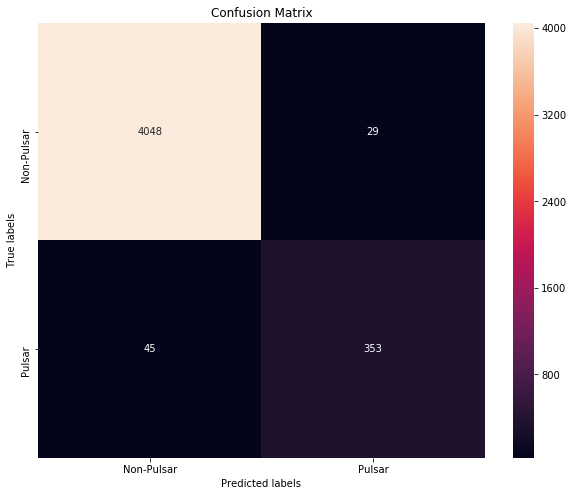

In [82]:
conf_matrix = confusion_matrix(testY, predictions)

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt     

plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, fmt='d') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Pulsar', 'Pulsar'])
ax.yaxis.set_ticklabels(['Non-Pulsar', 'Pulsar'])
plt.savefig('confusion_matrix_wcw.png')

As we want to classify the class labeled 1 (Pulsar stars), we are especially interessed in obtain a low rate of false negatives. What I mean is, our classes are extremely unbalanced, if we only care about accuracy and obtain high rate of false negatives, it means that our network is not performing well on what it was created for. 

What I did here was tuning the parameters of the network to obtain the least rate of false negatives while increasing accuracy. The drawback of this approach was that as the false negative occurrencies decreased so increased the occurencies of false positives. In a real worl context, this means that we are better at classifying Pulsar stars, meanwhile our network fails more in classify a Non-pulsar Star as a Pulsar Star (There's no free lunch, you know). Particularly, this behavior is worth because we will be predicting better at what the classifier was meant for. For those who are not acquainted with statistics, the false negative occurrencies are in the bottom -left cell of the confusion matrix and the false positive one are at the top-right cell. 

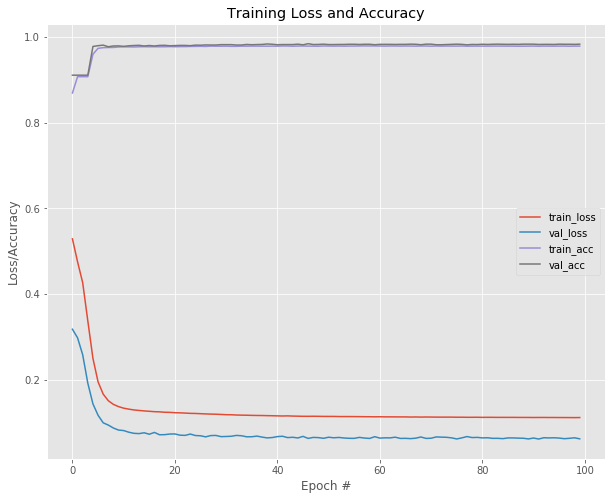

In [84]:
# Plotting the curve Epoch vs. Loss/Accuracy
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('plot_wcw.png')

Note that the training loss is much higher than the testing loss, why is it?

A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time.

Besides, the training loss is the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

For more informations, see:
http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/
https://forums.fast.ai/t/validation-loss-lower-than-training-loss/4581/2

Another Important metric for this problem is the Area Under Roc Curve, which can be seen following. Note that the model achieved a very good result, yieling a value greater than 0.93.

In [85]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, predictions)

auc_keras = auc(fpr_keras, tpr_keras)

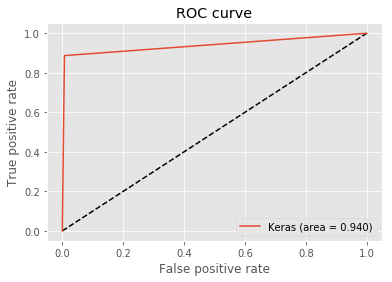

In [86]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [87]:
#from ann_visualizer.visualize import ann_viz;

#ann_viz(model, view=True, title="Neural Network")